<h2> Forcasting Demand on Bike Sharing </h2>
<h3> This consist of 3 notebook  </h3>
    <h4> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1 biketrain-data_preparation.ipynb    </h4>
    <h4> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2 biketrain-xgboost_training.ipynb    </h4>
    <h4> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3 biketrain-xgboost_prediction.ipynb  </h4>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h4>To download dataset, sign-in and download from this link: https://www.kaggle.com/c/bike-sharing-demand/data</h4>
<br>
Input Features (X): ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']<br>
Target Feature (Y): ['count']<br>

<b>Objective:</b> <quote>You are provided hourly rental data spanning two years (2011 & 2012). 

<b> Training set </b> :- First 19 days of each month [ Jan 1-19, Feb 1-19 etc],

<b> Test set is  </b> :- 20th to the end of the month [Jan 20-30, feb 20-28 etc.]. 

You must predict the total count of bikes rented during each hour covered by the test set </quote>

In [2]:
# Column is appended to the dataset at the end of this notebook. 
columns = ['count', 'season', 'holiday', 'workingday', 'weather', 'temp',
           'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'dayofweek','hour']

In [3]:
# parse_dates=['datetime'] is to  convert the "datetime" to date field. 
df      =  pd.read_csv('train.csv', parse_dates=['datetime'])
df_test =  pd.read_csv('test.csv',  parse_dates=['datetime'])

In [48]:
# delete this - data exploration. 
#df1 =  pd.read_csv('bike_validation_del.csv') #,  parse_dates=['datetime'])
#df1.head()

,count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour
0,443,3,0,1,2,28.70,33.335,79,12.9980,2011,7,7,3,8
1,387,2,0,0,1,32.80,37.880,55,12.9980,2011,6,11,5,13
2,2,1,0,1,1,14.76,16.665,40,19.9995,2011,2,14,0,2
3,48,1,0,1,1,9.02,9.090,47,36.9974,2011,2,8,1,10
4,55,4,0,0,1,10.66,15.150,87,0.0000,2011,12,4,6,8


In [5]:
# "Row_no 430": 2011-01-19 (Jan), "Row_no 431": 2011-02-01 (Feb) 
df.iloc[425:435,]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
425,2011-01-19 18:00:00,1,0,1,1,13.94,15.910,61,19.0012,5,156,161
426,2011-01-19 19:00:00,1,0,1,1,13.12,14.395,57,27.9993,4,108,112
427,2011-01-19 20:00:00,1,0,1,1,13.12,15.150,49,19.9995,2,74,76
428,2011-01-19 21:00:00,1,0,1,1,13.12,14.395,49,27.9993,4,55,59
429,2011-01-19 22:00:00,1,0,1,1,12.30,15.150,52,11.0014,6,53,59
430,2011-01-19 23:00:00,1,0,1,1,12.30,13.635,52,31.0009,1,27,28
431,2011-02-01 00:00:00,1,0,1,2,6.56,9.090,64,7.0015,2,6,8
432,2011-02-01 01:00:00,1,0,1,2,6.56,9.090,69,7.0015,0,3,3
433,2011-02-01 02:00:00,1,0,1,2,6.56,11.365,69,0.0000,0,2,2
434,2011-02-01 03:00:00,1,0,1,2,6.56,11.365,69,0.0000,0,2,2


In [6]:
# first 5 rows of test dataset
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
# We need to convert datetime to numeric for training.
# Let's extract key features into separate numeric columns
def add_features(df):
    df['year']      = df['datetime'].dt.year
    df['month']     = df['datetime'].dt.month
    df['day']       = df['datetime'].dt.day
    df['dayofweek'] = df['datetime'].dt.dayofweek
    df['hour']      = df['datetime'].dt.hour

In [8]:
add_features(df)
add_features(df_test)

In [9]:
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,5,4
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1,2011,1,1,5,5
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2,2011,1,1,5,6
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3,2011,1,1,5,7
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8,2011,1,1,5,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14,2011,1,1,5,9


In [10]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
hour                   int64
dtype: object

In [49]:
# Correlation - how strongly features are related to the "count" (output); value ranges from (0[no corr] - 1 [clone])
df1.corr()['count']

count         1.000000
season        0.178920
holiday       0.002620
workingday    0.030342
weather      -0.129463
temp          0.393004
atemp         0.388451
humidity     -0.313159
windspeed     0.108744
year          0.258325
month         0.185202
day           0.040384
dayofweek    -0.021388
hour          0.411163
Name: count, dtype: float64

In [50]:
# Everyday is seperated in hours and take average of bike sharing count in those hours. 
group_hour = df.groupby(['hour'])
average_by_hour = group_hour['count'].mean()

In [13]:
#delete this line ... data exploration. 
#group_hour = df.groupby(['month'])
#average_by_hour = group_hour['count'].mean()

In [14]:
print (average_by_hour)

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: count, dtype: float64


Text(0.5, 1.0, 'Rental Count Average by hour')

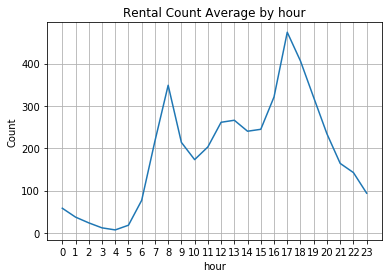

In [51]:
plt.plot(average_by_hour.index,average_by_hour)
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by hour')

In [52]:
group_year_hour = df.groupby(['year','hour'])

In [53]:
average_year_hour = group_year_hour['count'].mean()

In [54]:
print(average_year_hour)

year  hour
2011  0        41.097222
      1        29.038462
      2        20.932203
      3         8.379310
      4         6.214286
      5        13.780822
      6        55.400000
      7       157.075758
      8       259.821918
      9       166.753425
      10      129.057143
      11      154.295082
      12      183.223684
      13      194.671875
      14      192.028986
      15      183.184211
      16      233.880597
      17      368.703125
      18      309.166667
      19      234.898551
      20      172.085714
      21      130.229730
      22      109.909091
      23       70.129032
2012  0        77.169231
      1        44.296703
      2        25.717949
      3        14.895522
      4         7.716667
      5        23.800000
      6       100.531250
      7       267.435897
      8       451.809524
      9       270.933333
      10      219.696970
      11      244.347222
      12      348.588235
      13      327.000000
      14      298.403509
      15      

In [55]:
for year in average_year_hour.index.levels[0]:
    print (year)
    print(average_year_hour[year])

2011
hour
0      41.097222
1      29.038462
2      20.932203
3       8.379310
4       6.214286
5      13.780822
6      55.400000
7     157.075758
8     259.821918
9     166.753425
10    129.057143
11    154.295082
12    183.223684
13    194.671875
14    192.028986
15    183.184211
16    233.880597
17    368.703125
18    309.166667
19    234.898551
20    172.085714
21    130.229730
22    109.909091
23     70.129032
Name: count, dtype: float64
2012
hour
0      77.169231
1      44.296703
2      25.717949
3      14.895522
4       7.716667
5      23.800000
6     100.531250
7     267.435897
8     451.809524
9     270.933333
10    219.696970
11    244.347222
12    348.588235
13    327.000000
14    298.403509
15    313.500000
16    405.884058
17    565.135135
18    522.133333
19    396.552632
20    296.623188
21    198.493151
22    169.179104
23    116.640625
Name: count, dtype: float64


In [56]:
print(average_year_hour.index.levels[0])

Int64Index([2011, 2012], dtype='int64', name='year')


Text(0.5, 1.0, 'Rental Count Average by Year,Hour')

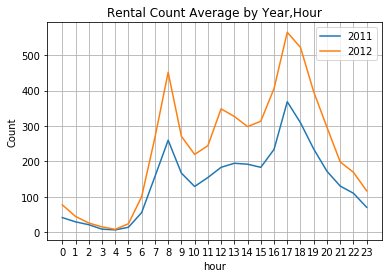

In [57]:
for year in average_year_hour.index.levels[0]:
    #print (year)
    #print(average_year_hour[year])
    plt.plot(average_year_hour[year].index,average_year_hour[year],label=year)
    
plt.legend()    
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by Year,Hour')

In [22]:
group_workingday_hour = df.groupby(['workingday','hour'])

In [23]:
average_workingday_hour = group_workingday_hour['count'].mean()

In [24]:
print(average_workingday_hour)

workingday  hour
0           0        94.489655
            1        71.910345
            2        53.748252
            3        25.534722
            4         8.544828
            5         9.373239
            6        19.993103
            7        47.268966
            8       112.255172
            9       177.924138
            10      263.806897
            11      325.386207
            12      379.110345
            13      387.820690
            14      378.731034
            15      373.703448
            16      367.648276
            17      339.124138
            18      292.248276
            19      242.344828
            20      183.806897
            21      148.737931
            22      123.351724
            23       90.606897
1           0        36.732258
            1        16.003236
            2         8.436066
            3         4.892734
            4         5.363636
            5        24.529032
            6       102.577419
            7       29

Text(0.5, 1.0, 'Rental Count Average by Working Day,Hour')

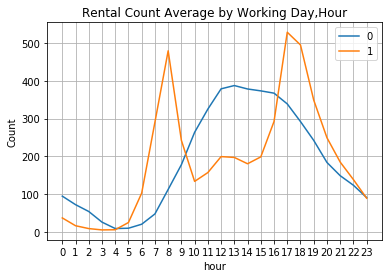

In [25]:
for workingday in average_workingday_hour.index.levels[0]:
    #print (year)
    #print(average_year_month[year])
    plt.plot(average_workingday_hour[workingday].index,average_workingday_hour[workingday],label=workingday)
    
plt.legend()    
plt.xlabel('hour')
plt.ylabel('Count')
plt.xticks(np.arange(24))
plt.grid(True)
plt.title('Rental Count Average by Working Day,Hour')

In [26]:
df.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
year                   int64
month                  int64
day                    int64
dayofweek              int64
hour                   int64
dtype: object

In [27]:
# Save all data
df.to_csv('bike_all.csv',index=False,
          columns=columns)

## Training and Validation Set
### Target Variable as first column followed by input features
### Training, Validation files do not have a column header

In [28]:
# Training = 70% of the data
# Validation = 30% of the data
# Randomize the entire datset
np.random.seed(5)
l = list(df.index)
np.random.shuffle(l)
df = df.iloc[l]

In [44]:
list(df)

['datetime',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'casual',
 'registered',
 'count',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour']

TypeError: 'Index' object is not callable

In [29]:
rows = df.shape[0]
train = int(.7 * rows)
test = int(.3 * rows)

In [30]:
rows, train, test

(10886, 7620, 3265)

In [31]:
list(columns)

['count',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'month',
 'day',
 'dayofweek',
 'hour']

In [32]:
# Write Training Set
df[:train].to_csv('bike_train.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [45]:
# Write Validation Set
df[train:].to_csv('bike_validation.csv'
                          ,index=False,header=False
                          ,columns=columns)

In [34]:
# Test Data has only input features
df_test.to_csv('bike_test.csv',index=False)

In [35]:
','.join(columns)

'count,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,hour'

In [36]:
# Write Column List
with open('bike_train_column_list.txt','w') as f:
    f.write(','.join(columns))